In [1]:
import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np
import ray
from ray.rllib.agents import ppo

from mdps.cliff import ContextualCliff
from utils.distributions import ConstantDistribution, ParticleDistribution, UniformDistribution

In [2]:
# some utils used later

def prepare_animation(bar_container_, context_history_):
    """Used for animated plotting sampling precedure"""
    def animate(frame_number, data=context_history_):
        # simulate new data coming in
        x = data[frame_number][:, 1]
        n, _ = np.histogram(x, HIST_BINS)
        plt.title(f'{frame_number} posterior mean: {round(x.mean(), 5)}')
        for count, rect in zip(n, bar_container_.patches):
            rect.set_height(count)
        return bar_container_.patches

    return animate


# collect expert rollout

def get_rollouts(solver_, config):
    """Generate rollouts from a given solver and MDP(c)"""
    env_ = ContextualCliff(config=config)
    done_ = False
    obs_ = env_.reset()
    # run until episode ends
    gt_obs_arr_ = None
    gt_act_arr_ = None
    while not done_:
        action_ = solver_.compute_single_action(obs_)
        obs_, _, done_, _ = env_.step(action_)
        if gt_obs_arr_ is None:
            gt_obs_arr_ = obs_
            gt_act_arr_ = [action_]
        else:
            gt_obs_arr_ = np.vstack((gt_obs_arr_, obs_))
            gt_act_arr_ += [action_]

    gt_act_arr_ = np.array(gt_act_arr_)
    return gt_obs_arr_, gt_act_arr_

def plot_rollouts(gt_obs_arr_, gt_act_arr_):
    """Plot generated rollouts"""
    fig_, ax_1 = plt.subplots()
    fig_.set_size_inches(10, 6, forward=True)

    x = np.arange(start=0, stop=gt_obs_arr_.shape[0])
    ax_2 = ax_1.twinx()
    ax_1.plot(x, gt_obs_arr_[:, 0], 'r-')
    ax_2.plot(x, gt_act_arr_, 'b-', alpha=0.3)

    ax_1.set_xlabel('time step')
    ax_1.set_ylabel('Position (x)', color='r')
    ax_2.set_ylabel('Action', color='b')
    plt.title('sample observations and actions')
    plt.show()

# Contextual "cliff"

This notebook studies using particle filtering to estimate the context parameters of a standard `Cliff` environment in `mdps.cliff`.

The `Cliff` environment has a cart that chooses either to go left or right for a `step_size`. It starts at the `mid_point` of the `right_end` and the `left_end`, and it receives a reward proportional to the power (default set to 2) of its current location, `x`. If it "falls off the cliff" from the left or right end, however, it receives a highly negative reward and the episode ends. Also, there are noise and drift terms, and the state-transition equation of the position `x` is (where `action` is 0 or 1 for moving left or right):
\
$x_{t+1} = N(0, \text{noise}) - \text{drift} * x + 2 * (\text{action}-0.5) * \text{stepsize}$

Thus, the goal of the cart is to keep its position `x` as large as possible (i.e. close to the larger end) and in the meantime keep a distance to that end to prevent accidentally falling off due to the transition noise.

The context params are: `(left_bound, right_bound, pow, step_size, noise, drift)`.

# Set target

We first create a target config, $c$. This will be the $MDP(c)$ the expert uses to generate the observational data.

In [3]:
# true (expert) context: (left_bound, right_bound, pow, step_size, noise, drift) =
#                         [0.0, 2.0, 2.0, 0.05, 0.05, 0.0]
c = {'context_distribution':
         ConstantDistribution(dim=6,
                              constant_vector=np.array([0.0, 2, 2, 0.05, 0.05, 0.0]))}

First, train an expert that masters this context.

In [4]:
ray.shutdown()
ray.init()
expert = ppo.PPOTrainer(env=ContextualCliff, config={
    "env_config": c,
    "framework": "torch",  # config to pass to env class
})

rews = []
for eps in range(25):
    res = expert.train()
    if eps % 5 == 0:
        print(eps, res['episode_reward_mean'])
    rews += [res['episode_reward_mean']]

2022-02-15 15:22:36,530	INFO services.py:1340 -- View the Ray dashboard at http://127.0.0.1:8265
2022-02-15 15:22:37,581	INFO ppo.py:167 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.
2022-02-15 15:22:37,582	INFO trainer.py:745 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
2022-02-15 15:22:39,026	WARNING util.py:57 -- Install gputil for GPU system monitoring.


0 -88.66576244337308
5 67.13376214381836
10 136.99750818077538
15 141.98826132903562
20 148.1049628828176


In [14]:
# collect expert rollout
gt_obs_arr, gt_act_arr = get_rollouts(expert, config=c)

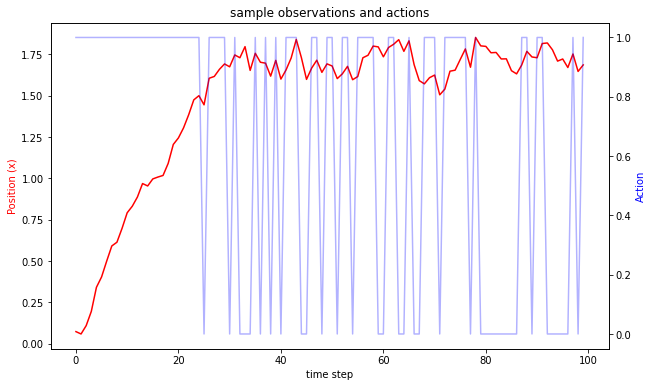

In [15]:
plot_rollouts(gt_obs_arr, gt_act_arr)

In [19]:
np.save("gtobs.npy", gt_obs_arr)
np.save("gtact.npy", gt_act_arr)

In [3]:
gt_act_arr = np.load("gtact.npy")
gt_obs_arr = np.load("gtobs.npy")

## Exact context

We first train a RL solver only on the correct context for particle filtering. We have already done this so we can directly use the expert solver.

In [4]:
# true (expert) context: (left_bound, right_bound, pow, step_size, noise, drift) =
#                       [0.0, 2.0, 2.0, 0.025, 0.05, 0.0]

N = 1000
T = 100
left_bound = np.ones((N,)) * 0.0
pow = np.ones((N,)) * 2
drift = np.random.normal(loc=0.00, scale=0.001, size=(N,))
step_size = np.ones((N,)) * 0.025

In [5]:
def filter_context(solver_,
                   context_distribution_,
                   gt_obs_arr_,
                   T_,
                   N_
                   ):
    state_arr_ = np.zeros((N_,))
    action_arr_ = np.zeros((N_,))
    context_history_ = []
    for t_ in range(T_):
        # we only use the first 5 steps of the cartpole steps to reduce effect of different episode lengths
        qs_ = np.zeros((N_,))
        for n_ in range(N_):
            context_ = context_distribution_.particles[n_]
            c_local_ = {'context_distribution':
                           ConstantDistribution(dim=6,
                                                constant_vector=context_)}
            env_ = ContextualCliff(config=c_local_)
            obs_ = env_.reset()
            if t_ > 0:
                env_.mdp.x = state_arr_[n_]
                obs_ = np.concatenate((np.array([env_.mdp.x]), context_), axis=0).flatten()
            action_ = solver_.compute_single_action(obs_)
            obs_, _, done_, _ = env_.step(action_)
            # estimate likelihood if r >= 1
            if t_ >= 1:
                q = env_.likelihood(gt_obs_arr_[t_ - 1], action_arr_[n_], obs_)
                qs_[n_] = q
            state_arr_[n_] = np.copy(env_.mdp.x)
            action_arr_[n_] = action_
        if t_ >= 1:
            # truncated importance sampling; [https://arxiv.org/pdf/1905.09800.pdf]
            qs_ = np.clip(qs_, 0, np.percentile(qs_, 90))
            qs_ = qs_ / qs_.sum()
            resample_index_ = context_distribution_.resample_particles_from_probability(p=qs_)
            p_temp_ = context_distribution_.particles
            p_noise_ = np.random.normal(loc=0, scale=p_temp_.std(axis=0), size=p_temp_.shape) * 0.05
            context_distribution_.particles += p_noise_
            state_arr_ = state_arr_[resample_index_]
            action_arr_ = action_arr_[resample_index_]
        if t_ % 25 == 0:
            print("round", t_, "posterior mean", context_distribution_.particles[:, 1].mean())
        context_history_ += [context_distribution_.particles.copy()]
    return context_history_, context_distribution_

In [ ]:
right_bound = np.random.normal(loc=2.5, scale=0.5, size=(N,))
noise = np.ones((N,)) * 0.05

context_particles = np.abs(np.vstack((left_bound, right_bound, pow, step_size, noise, drift)).T)
context_distribution = ParticleDistribution(dim=6, particles=context_particles, n_particles=N)

context_history_exact, _ = filter_context(expert,
                                   context_distribution,
                                   gt_obs_arr,
                                   T,
                                   N
                                   )

In [ ]:
HIST_BINS = np.linspace(1, 3, 120)

fig, ax = plt.subplots()
plt.axvline(x=2.0, alpha=0.3, color='black', linestyle='--')
plt.legend(['ground truth: 2.0'])
_, _, bar_container = ax.hist(context_history_exact[0][:, 1], HIST_BINS, lw=1,
                              ec="cyan", fc="blue", alpha=0.5)
ax.set_ylim(top=N / 4)  # set safe limit to ensure that all data is visible.

ani = animation.FuncAnimation(fig, prepare_animation(bar_container, context_history_exact),
                              len(context_history_exact),
                              repeat=True, blit=False, interval=100, repeat_delay=500)
prior_mean = 2.5
posterior_mean = round(context_history_exact[-1][:, 1].mean(), 3)
ani.save(f'prior_{prior_mean}_posterior{posterior_mean}.mp4', dpi=300)
plt.show()

In [ ]:
fig, ax = plt.subplots()
HIST_BINS = np.linspace(1, 4, 80)
ax.hist(context_history_exact[0][:, 1], HIST_BINS, lw=1,
        ec="blue", fc="blue", alpha=0.5)
ax.hist(context_history_exact[-1][:, 1], HIST_BINS, lw=1,
        ec="red", fc="red", alpha=0.5)
plt.axvline(x=2, alpha=0.3, color='black', linestyle='--')
plt.legend(['ground truth: 2.0', 'prior', 'posterior'])
ax.set_ylim(top=N / 5)
fig.set_size_inches(12, 8)
plt.title('solver trained in exactly specified context')
plt.show()

In [ ]:
# We reduce the right end from 2.0 to 1.5 and keep otherwise the same.
c_mis = {'context_distribution':
             ConstantDistribution(dim=5,
                                  constant_vector=np.array([0.0, 1.5, 2.0, 0.025, 0.05, 0.0]))}

ray.shutdown()
ray.init()
mis_solver = ppo.PPOTrainer(env=ContextualCliff, config={
    "env_config": c_mis,
    "framework": "torch",  # config to pass to env class
})

for eps in range(25):
    res = mis_solver.train()
    if eps % 5 == 0:
        print(eps, res['episode_reward_mean'])

In [ ]:
mis_obs_arr, mis_act_arr = get_rollouts(mis_solver, config=c)
plot_rollouts(mis_obs_arr, mis_act_arr)

In [ ]:
# true (expert) context: (left_bound, right_bound, pow, step_size, noise, drift) =
#                       [0.0, 3.0, 2.0, 0.025, 0.05, 0.0]

right_bound = np.random.normal(loc=2.5, scale=0.5, size=(N,))
noise = np.ones((N,)) * 0.05

context_particles = np.abs(np.vstack((left_bound, right_bound, pow, step_size, noise, drift)).T)
context_distribution = ParticleDistribution(dim=6, particles=context_particles, n_particles=N)

context_history_mis, _ = filter_context(mis_solver,
                                       context_distribution,
                                       gt_obs_arr,
                                       T,
                                       N
                                       )

In [ ]:
fig, ax = plt.subplots()
HIST_BINS = np.linspace(1, 5, 80)
ax.hist(context_history_mis[0][:, 1], HIST_BINS, lw=1,
        ec="blue", fc="blue", alpha=0.5)
ax.hist(context_history_mis[-1][:, 1], HIST_BINS, lw=1,
        ec="red", fc="red", alpha=0.5)
plt.axvline(x=2, alpha=0.3, color='black', linestyle='--')
plt.legend(['ground truth: 2.0', 'prior', 'posterior'])
ax.set_ylim(top=N / 5)
fig.set_size_inches(12, 8)
plt.title('solver trained in mis-specified context')
plt.show()

# Uniformly sampled context

We uniformly sample contexts during training, a common way to perform domain randomization.

In [11]:
c_uniform = {'context_distribution':
             UniformDistribution(dim=6,
                              lower_bound_vector=np.array([0.0, 1.0, 2, 0.05, 0.05, 0.0]),
                              upper_bound_vector=np.array([0.0, 3.0, 2, 0.05, 0.05, 0.0]))}

In [12]:
ray.shutdown()
ray.init()
uniform_solver = ppo.PPOTrainer(env=ContextualCliff, config={
                                                    "env_config": c_uniform,
                                                    "framework": "torch",  # config to pass to env class
                                                })

rews = []
for eps in range(25):
    res = uniform_solver.train()
    if eps % 5 == 0:
        print(eps, res['episode_reward_mean'])
    rews += [res['episode_reward_mean']]

RuntimeError: Couldn't start Redis. Check log files: /tmp/ray/session_2022-02-15_15-20-49_234319_2108/logs/redis.out /tmp/ray/session_2022-02-15_15-20-49_234319_2108/logs/redis.err

In [ ]:
plot_rollouts(*get_rollouts(uniform_solver,
                           config={'context_distribution':
                                    ConstantDistribution(dim=5,
                                    constant_vector=np.array([0.0, 1.5, 2.0, 0.05, 0.05, 0.0]))}))

In [ ]:
plot_rollouts(*get_rollouts(uniform_solver,
                           config={'context_distribution':
                                    ConstantDistribution(dim=5,
                                    constant_vector=np.array([0.0, 2.5, 2.0, 0.05, 0.05, 0.0]))}))

In [ ]:
right_bound = np.random.normal(loc=2.5, scale=0.5, size=(N,))
noise = np.ones((N,)) * 0.05

context_particles = np.abs(np.vstack((left_bound, right_bound, pow, step_size, noise, drift)).T)
context_distribution = ParticleDistribution(dim=6, particles=context_particles, n_particles=N)

context_history_uniform = filter_context(uniform_solver,
                                           context_distribution,
                                           gt_obs_arr,
                                           T,
                                           N
                                           )

In [ ]:
fig, ax = plt.subplots()
HIST_BINS = np.linspace(1, 4, 80)
ax.hist(context_history_uniform[0][:, 1], HIST_BINS, lw=1,
        ec="blue", fc="blue", alpha=0.5)
ax.hist(context_history_uniform[-1][:, 1], HIST_BINS, lw=1,
        ec="red", fc="red", alpha=0.5)
plt.axvline(x=2, alpha=0.3, color='black', linestyle='--')
plt.legend(['ground truth: 2.0', 'prior', 'posterior'])
ax.set_ylim(top=N / 5)
fig.set_size_inches(12, 8)
plt.title('solver trained in uniformly sampled context')
plt.show()

# Importance sampling for context

We do training - PF filtering update - training loop.

2022-02-15 16:03:33,701	INFO services.py:1340 -- View the Ray dashboard at http://127.0.0.1:8265
2022-02-15 16:03:34,714	INFO ppo.py:167 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.
2022-02-15 16:03:34,715	INFO trainer.py:745 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
2022-02-15 16:03:36,090	WARNING util.py:57 -- Install gputil for GPU system monitoring.


round 0 posterior mean 2.910317114527295
round 25 posterior mean 3.231093370868455
round 50 posterior mean 3.0246796856279157
round 75 posterior mean 2.268511360021181


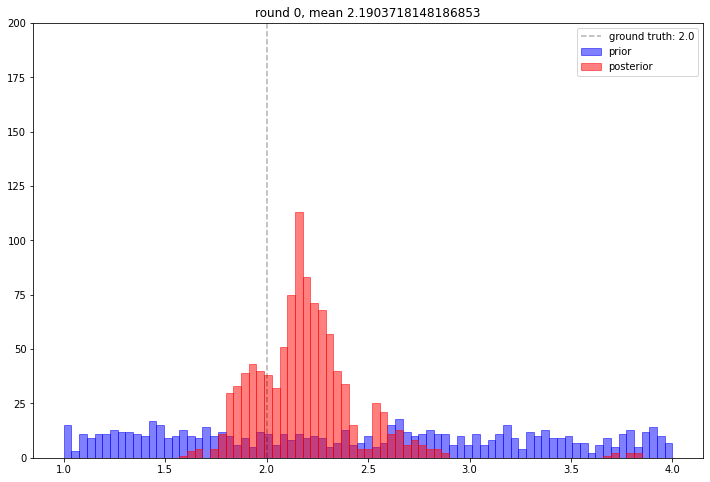

round 0 posterior mean 2.1903718148186853
round 25 posterior mean 2.274505710946588
round 50 posterior mean 2.203005243348516
round 75 posterior mean 2.1668006328212934


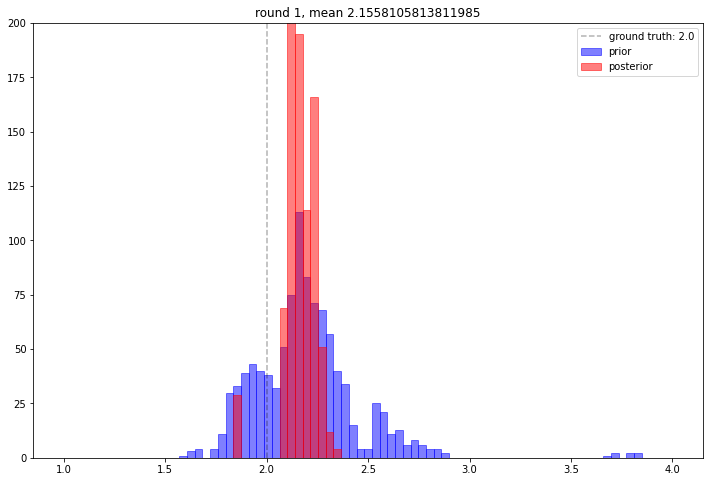

round 0 posterior mean 2.1558105813811985
round 25 posterior mean 2.1515946659641094
round 50 posterior mean 2.1389934013258616
round 75 posterior mean 2.134526022982813


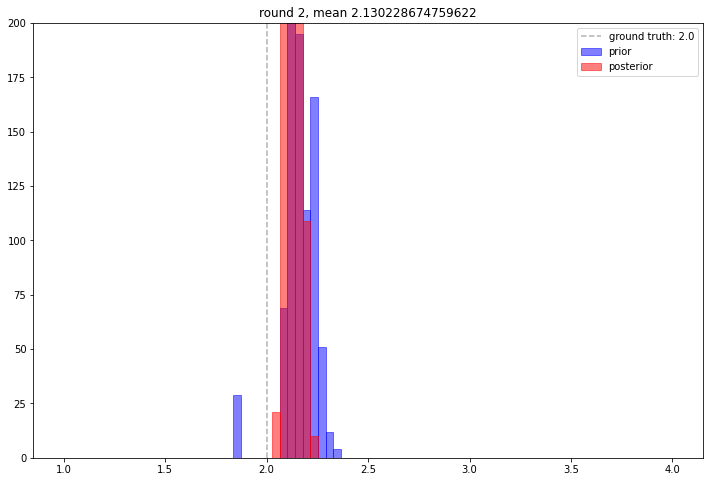

In [6]:
# Initialize uniform prior of right_bound

right_bound = np.random.uniform(1, 5, size=(N,))
noise = np.ones((N,)) * 0.05

prior_context_particles = np.abs(np.vstack((left_bound, right_bound, pow, step_size, noise, drift)).T)
imp_context_distribution = ParticleDistribution(dim=6, particles=prior_context_particles, n_particles=N)

ray.shutdown()
ray.init()

# ray.init(address="auto")
imp_solver = ppo.PPOTrainer(env=ContextualCliff, config={
                                                "env_config":  {'context_distribution': imp_context_distribution},
                                                "framework": "torch",  # config to pass to env class
                                            })

for update_round in range(3):
    # burn in training
    if update_round == 0:
        for i in range(15):
            imp_solver.train()

    context_history_imp, imp_context_distribution = filter_context(imp_solver,
                                       imp_context_distribution,
                                       gt_obs_arr,
                                       T,
                                       N
                                       )

    fig, ax = plt.subplots()
    HIST_BINS = np.linspace(1, 4, 80)
    ax.hist(context_history_imp[0][:, 1], HIST_BINS, lw=1,
            ec="blue", fc="blue", alpha=0.5)
    ax.hist(context_history_imp[-1][:, 1], HIST_BINS, lw=1,
            ec="red", fc="red", alpha=0.5)
    plt.axvline(x=2, alpha=0.3, color='black', linestyle='--')
    plt.legend(['ground truth: 2.0', 'prior', 'posterior'])
    ax.set_ylim(top=N / 5)
    fig.set_size_inches(12, 8)
    plt.title(f'round {update_round}, mean {context_history_imp[-1][:, 1].mean()}')
    plt.show()

    imp_solver.workers.foreach_worker(
                lambda ev: ev.foreach_env(
                    lambda env: env.set_task(imp_context_distribution)))
    for _ in range(4):
        imp_solver.train()


In [18]:
imp_context_distribution.sample().shape

(1, 6)